In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report



In [2]:
dataset=r'./dataset/'
imagePaths=list(paths.list_images(dataset))

In [3]:
print(imagePaths[0:5])

['./dataset/mask_weared_incorrect\\1.png', './dataset/mask_weared_incorrect\\10.png', './dataset/mask_weared_incorrect\\100.png', './dataset/mask_weared_incorrect\\1000.png', './dataset/mask_weared_incorrect\\1001.png']


In [4]:
data=[]
labels=[]

for i in imagePaths:
    label=i.split(os.path.sep)[-2]
    labels.append(label)
    image=load_img(i,target_size=(224,224))
    image=img_to_array(image)
    image=preprocess_input(image)
    data.append(image)
   

In [5]:
data

[array([[[ 0.8509804 ,  0.64705884,  0.37254906],
         [ 0.8509804 ,  0.64705884,  0.37254906],
         [ 0.84313726,  0.6313726 ,  0.37254906],
         ...,
         [-0.7019608 , -0.70980394, -0.7176471 ],
         [-0.69411767, -0.7019608 , -0.70980394],
         [-0.69411767, -0.7019608 , -0.70980394]],
 
        [[ 0.8509804 ,  0.64705884,  0.37254906],
         [ 0.8509804 ,  0.64705884,  0.37254906],
         [ 0.84313726,  0.6313726 ,  0.37254906],
         ...,
         [-0.7019608 , -0.70980394, -0.7176471 ],
         [-0.69411767, -0.7019608 , -0.70980394],
         [-0.69411767, -0.7019608 , -0.70980394]],
 
        [[ 0.90588236,  0.7176471 ,  0.4431373 ],
         [ 0.90588236,  0.7176471 ,  0.4431373 ],
         [ 0.90588236,  0.73333335,  0.47450984],
         ...,
         [-0.7176471 , -0.7176471 , -0.73333335],
         [-0.7176471 , -0.7254902 , -0.73333335],
         [-0.7176471 , -0.7254902 , -0.73333335]],
 
        ...,
 
        [[-0.29411763, -0.30196077

In [6]:
encoded_labels=[]
for label in labels:
    if(label=="./dataset/with_mask"):
        encoded_labels.append(0)
    elif(label=="./dataset/without_mask"):
        encoded_labels.append(1)
    if(label=="./dataset/mask_weared_incorrect"):
        encoded_labels.append(2)

In [7]:
data=np.array(data,dtype='float32')
encoded_labels=np.array(encoded_labels)

In [8]:
data.shape

(8982, 224, 224, 3)

In [9]:
encoded_labels

array([2, 2, 2, ..., 0, 0, 0])

In [10]:
labels=to_categorical(y=encoded_labels,num_classes=3)

In [11]:
labels

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [12]:
train_X,test_X,train_Y,test_Y=train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=10)

In [13]:
train_X.shape

(7185, 224, 224, 3)

In [14]:
train_Y.shape

(7185, 3)

In [15]:
test_X.shape

(1797, 224, 224, 3)

In [16]:
test_Y.shape

(1797, 3)

In [17]:
aug=ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,vertical_flip=True,fill_mode='nearest')

In [18]:
baseModel=MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

In [19]:
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [20]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='Flatten')(headModel)
headModel=Dense(128,activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(3,activation='softmax')(headModel)

model=Model(inputs=baseModel.input,outputs=headModel)

In [21]:
for layer in baseModel.layers:
    layer.trainable=False

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [23]:
learning_rate=0.001
Epochs=20
BS=12

opt=Adam(learning_rate=learning_rate,decay=learning_rate/Epochs)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

H=model.fit(
    aug.flow(train_X,train_Y,batch_size=BS),
    steps_per_epoch=len(train_X)/BS,
    validation_data=(test_X,test_Y),
    validation_steps=len(test_X)/BS,
    epochs=Epochs
)

Epoch 1/20
598/598 [==============================] - 243s 398ms/step - loss: 0.3497 - accuracy: 0.8643 - val_loss: 0.1840 - val_accuracy: 0.9238
Epoch 2/20
598/598 [==============================] - 217s 362ms/step - loss: 0.2508 - accuracy: 0.9056 - val_loss: 0.1423 - val_accuracy: 0.9471
Epoch 3/20
598/598 [==============================] - 212s 354ms/step - loss: 0.2321 - accuracy: 0.9120 - val_loss: 0.1772 - val_accuracy: 0.9310
Epoch 4/20
598/598 [==============================] - 211s 352ms/step - loss: 0.2112 - accuracy: 0.9247 - val_loss: 0.1306 - val_accuracy: 0.9477
Epoch 5/20
598/598 [==============================] - 216s 361ms/step - loss: 0.1889 - accuracy: 0.9283 - val_loss: 0.1977 - val_accuracy: 0.9176
Epoch 6/20
598/598 [==============================] - 212s 354ms/step - loss: 0.1755 - accuracy: 0.9324 - val_loss: 0.1611 - val_accuracy: 0.9327
Epoch 7/20
598/598 [==============================] - 211s 352ms/step - loss: 0.1739 - accuracy: 0.9336 - val_loss: 0.1452 -

In [24]:
model.save('mobilenet_v2.model')

INFO:tensorflow:Assets written to: mobilenet_v2.model\assets


C:\Users\ashis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\ashis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [25]:
classes=np.array(["with mask","without mask","mask weared incorrectly"])
classes

array(['with mask', 'without mask', 'mask weared incorrectly'],
      dtype='<U23')

In [26]:
predict=model.predict(test_X,batch_size=BS)
predict=np.argmax(predict,axis=1)
print(classification_report(test_Y.argmax(axis=1),predict,target_names=classes))

                         precision    recall  f1-score   support

              with mask       0.92      0.98      0.95       599
           without mask       0.97      0.96      0.97       599
mask weared incorrectly       0.98      0.92      0.95       599

               accuracy                           0.96      1797
              macro avg       0.96      0.96      0.96      1797
           weighted avg       0.96      0.96      0.96      1797



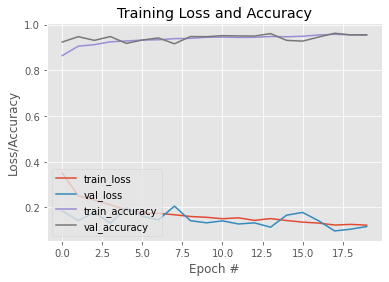

In [27]:
N = Epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(r'./plot_v2.png')